In [1]:
import json
import pandas as pd

in_data = json.load(open('../Bob_translate_result/B_in_result.json'))
out_data = json.load(open('../Bob_translate_result/B_out_result.json'))
data = list(in_data.values()) + list(out_data.values())
label = [0 for _ in range(len(list(in_data.values())))] + [1 for _ in range(len(list(out_data.values())))]
data_dict = {'ori': [data[i][0] for i in range(len(data))], 'gt': [data[i][1] for i in range(len(data))], 'pred': [data[i][2] for i in range(len(data))], 'label': label}
df = pd.DataFrame(data_dict)
df.head()

,ori,gt,pred,label
0,86. 爲此，糧農組織將考慮就如何設計1996年及其後年份的活動所提出的下述建議：,"In this connection, FAO will consider the foll...","86. To this end, FAO will consider the followi...",0
1,(a) 應當進一步開發變化矩陣系列的統計設計和分析系統：,(a) Statistical designs and analytical systems...,(a) The statistical design and analysis system...,0
2,㈠ 利用輔助資料，例如，藉助美國諾阿的高級甚高分辨率輻射 計（一公里分辨率）以及各種數據庫（...,(i) To use the auxiliary information such as t...,"(i) To use complementary information, such as ...",0
3,㈡ 通過可減少森林面積變化數字差異的分層參數改進對變化的 估測，如人口統計學參數，經濟指示數...,(ii) To improve estimates for change by strati...,(ii) Improving the estimation of changes throu...,0
4,(b) 應當進一步推動採用可靠的監測程序，如相互依賴的遙感分析，以獲得可協助決策的針對具體地...,(b) Sound monitoring procedures such as interd...,"(b) The use of reliable monitoring procedures,...",0


In [2]:
from nltk.translate.bleu_score import modified_precision, sentence_bleu, SmoothingFunction

def modified_n_gram_precisions(ref, hypo, n):
    return float(modified_precision([ref.split()], hypo.split(), n))

def bleu_score(ref, hypo):
    chencherry = SmoothingFunction()
    return sentence_bleu([ref.split()], hypo.split(), smoothing_function=chencherry.method1)

df['1-gram'] = df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 1), axis=1)
df['2-gram'] = df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 2), axis=1)
df['3-gram'] = df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 3), axis=1)
df['4-gram'] = df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 4), axis=1)
df['bleu'] = df.apply(lambda r: bleu_score(r['gt'], r['pred']), axis=1)
df.head()

,ori,gt,pred,label,1-gram,2-gram,3-gram,4-gram,bleu
0,86. 爲此，糧農組織將考慮就如何設計1996年及其後年份的活動所提出的下述建議：,"In this connection, FAO will consider the foll...","86. To this end, FAO will consider the followi...",0,0.684211,0.555556,0.470588,0.375000,0.508918
1,(a) 應當進一步開發變化矩陣系列的統計設計和分析系統：,(a) Statistical designs and analytical systems...,(a) The statistical design and analysis system...,0,0.500000,0.200000,0.142857,0.076923,0.182071
2,㈠ 利用輔助資料，例如，藉助美國諾阿的高級甚高分辨率輻射 計（一公里分辨率）以及各種數據庫（...,(i) To use the auxiliary information such as t...,"(i) To use complementary information, such as ...",0,0.465116,0.190476,0.097561,0.025000,0.121242
3,㈡ 通過可減少森林面積變化數字差異的分層參數改進對變化的 估測，如人口統計學參數，經濟指示數...,(ii) To improve estimates for change by strati...,(ii) Improving the estimation of changes throu...,0,0.625000,0.260870,0.090909,0.047619,0.156343
4,(b) 應當進一步推動採用可靠的監測程序，如相互依賴的遙感分析，以獲得可協助決策的針對具體地...,(b) Sound monitoring procedures such as interd...,"(b) The use of reliable monitoring procedures,...",0,0.500000,0.200000,0.041667,0.000000,0.062779


In [3]:
from sklearn.model_selection import train_test_split
X = df[['1-gram', '2-gram', '3-gram', '4-gram', 'bleu']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=902022)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print('The accuracy of Random Forest Classifier on training set:', rfc.score(X_train, y_train))
print('The accuracy of Random Forest Classifier on testing set:', rfc.score(X_test, y_test))

The accuracy of Random Forest Classifier on training set: 0.6971490384615384
The accuracy of Random Forest Classifier on testing set: 0.5206410256410257


In [5]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
print('The accuracy of eXtreme Gradient Boosting Classifier on training set:', xgbc.score(X_train, y_train))
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(X_test, y_test))

/tmp2/b07902022/anaconda3/envs/SPML/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of eXtreme Gradient Boosting Classifier on training set: 0.5500448717948718
The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.527301282051282


In [6]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_train, y_train)
print('The accuracy of MLP Classifier on training set:', clf.score(X_train, y_train))
print('The accuracy of MLP Classifier on testing set:', clf.score(X_test, y_test))


The accuracy of MLP Classifier on training set: 0.5268205128205128
The accuracy of MLP Classifier on testing set: 0.5261730769230769


In [7]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
print('The accuracy of KNN on testing set:', classifier.score(X_train, y_train))
print('The accuracy of KNN on testing set:', classifier.score(X_test, y_test))

The accuracy of KNN on testing set: 0.6023605769230769
The accuracy of KNN on testing set: 0.508224358974359


In [8]:
a_in_data = json.load(open('../Bob_translate_result/A_in_result.json'))
a_out_data = json.load(open('../Bob_translate_result/A_out_result.json'))
a_data = list(a_in_data.values()) + list(a_out_data.values())
a_label = [0 for _ in range(len(list(a_in_data.values())))] + [1 for _ in range(len(list(a_out_data.values())))]
a_data_dict = {'ori': [a_data[i][0] for i in range(len(a_data))], 'gt': [a_data[i][1] for i in range(len(a_data))], 'pred': [a_data[i][2] for i in range(len(a_data))], 'label': a_label}
a_df = pd.DataFrame(a_data_dict)
a_df.head()

a_df['1-gram'] = a_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 1), axis=1)
a_df['2-gram'] = a_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 2), axis=1)
a_df['3-gram'] = a_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 3), axis=1)
a_df['4-gram'] = a_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 4), axis=1)
a_df['bleu'] = a_df.apply(lambda r: bleu_score(r['gt'], r['pred']), axis=1)
a_df.head()

,ori,gt,pred,label,1-gram,2-gram,3-gram,4-gram,bleu
0,第918(1994)號決議,RESOLUTION 918 (1994),RESOLUTION 918 (1994) CONCERNING THE QUESTION ...,0,0.187500,0.133333,0.071429,0.000000,0.060879
1,1994年5月17日安全理事會第3377次會議通過,Adopted by the Security Council at its 3377th ...,Adopted on 17 May 1994 by the Security Council...,0,0.764706,0.687500,0.600000,0.500000,0.630191
2,安全理事會，,"The Security Council,","The Security Council,See Official Records of t...",0,0.117647,0.062500,0.000000,0.000000,0.024325
3,重申其以往關於盧旺達局勢的所有決議，特別是成立聯合國盧旺達援助團(聯盧援助團)的1993年1...,Reaffirming all its previous resolutions on th...,Reaffirming all its previous resolutions on th...,0,0.890909,0.722222,0.603774,0.500000,0.533743
4,回顧安理會主席以安理會名義在1994年4月7日發表的聲明(S/PRST/ 1994/16)和...,Recalling the statements made by the President...,Recalling the statements made by the President...,0,0.720000,0.708333,0.695652,0.681818,0.701306


In [9]:
a_X = a_df[['1-gram', '2-gram', '3-gram', '4-gram', 'bleu']]
a_y = a_df['label']
print('The accuracy of Random Forest Classifier on Alice set:', rfc.score(a_X, a_y))
print('The accuracy of eXtreme Gradient Boosting Classifier on Alice set:', xgbc.score(a_X, a_y))
print('The accuracy of MLP Classifier on Alice set:', clf.score(a_X, a_y))
print('The accuracy of KNN on Alice set:', classifier.score(a_X, a_y))

The accuracy of Random Forest Classifier on Alice set: 0.49504545454545457
The accuracy of eXtreme Gradient Boosting Classifier on Alice set: 0.48422727272727273
The accuracy of MLP Classifier on Alice set: 0.47654545454545455
The accuracy of KNN on Alice set: 0.49386363636363634


In [10]:
ood_data = json.load(open('../Bob_translate_result/A_ood_result.json'))
ood_data = list(ood_data.values())
ood_label = [1 for _ in range(len(ood_data))]
ood_data_dict = {'ori': [ood_data[i][0] for i in range(len(ood_data))], 'gt': [ood_data[i][1] for i in range(len(ood_data))], 'pred': [ood_data[i][2] for i in range(len(ood_data))], 'label': ood_label}
ood_df = pd.DataFrame(ood_data_dict)
ood_df.head()

ood_df['1-gram'] = ood_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 1), axis=1)
ood_df['2-gram'] = ood_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 2), axis=1)
ood_df['3-gram'] = ood_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 3), axis=1)
ood_df['4-gram'] = ood_df.apply(lambda r: modified_n_gram_precisions(r['gt'], r['pred'], 4), axis=1)
ood_df['bleu'] = ood_df.apply(lambda r: bleu_score(r['gt'], r['pred']), axis=1)
ood_df.head()

,ori,gt,pred,label,1-gram,2-gram,3-gram,4-gram,bleu
0,Brion VIBBER,Brion VIBBER,Breon VIBBER Qualified by the Secretary-Genera...,1,0.100000,0.0,0.0,0.0,0.021105
1,Mountain,Mountain,"Mount'ain, please. No, no, you don't. You know...",1,0.000000,0.0,0.0,0.0,0.000000
2,數學,Mathematics,Mathematics (mathematicals).. 6 - 4 4 - 5 4,1,0.111111,0.0,0.0,0.0,0.023980
3,目錄,Contents,Contents. 7 - 7 2 - 5 3 - 4 4 - 3 3 — 5 4,1,0.000000,0.0,0.0,0.0,0.000000
4,哲學,Philosophy,Philosophy (Psythropology).. 6 - 4 4 3,1,0.142857,0.0,0.0,0.0,0.033032


In [11]:
ood_X = ood_df[['1-gram', '2-gram', '3-gram', '4-gram', 'bleu']]
ood_y = ood_df['label']
print('The accuracy of Random Forest Classifier on Alice set:', rfc.score(ood_X, ood_y))
print('The accuracy of eXtreme Gradient Boosting Classifier on Alice set:', xgbc.score(ood_X, ood_y))
print('The accuracy of MLP Classifier on Alice set:', clf.score(ood_X, ood_y))
print('The accuracy of KNN on Alice set:', classifier.score(ood_X, ood_y))

The accuracy of Random Forest Classifier on Alice set: 0.719
The accuracy of eXtreme Gradient Boosting Classifier on Alice set: 0.722
The accuracy of MLP Classifier on Alice set: 0.134
The accuracy of KNN on Alice set: 0.245


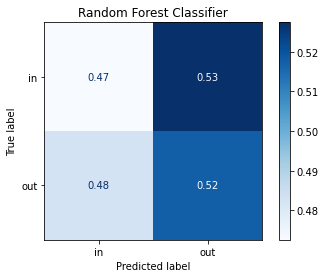

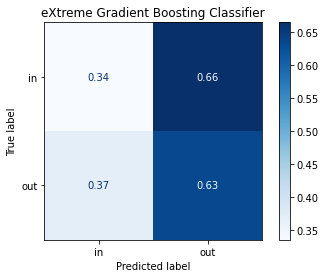

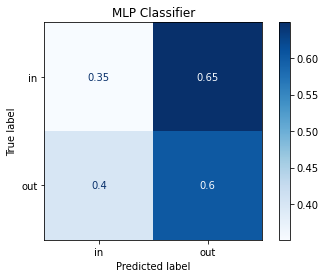

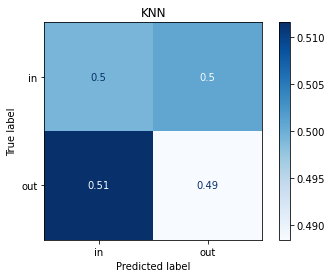

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(rfc, a_X, a_y, display_labels=['in', 'out'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Random Forest Classifier')
disp = ConfusionMatrixDisplay.from_estimator(xgbc, a_X, a_y, display_labels=['in', 'out'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('eXtreme Gradient Boosting Classifier')
disp = ConfusionMatrixDisplay.from_estimator(clf, a_X, a_y, display_labels=['in', 'out'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('MLP Classifier')
disp = ConfusionMatrixDisplay.from_estimator(classifier, a_X, a_y, display_labels=['in', 'out'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('KNN')
plt.show()